In [17]:
# Importations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

from histo_starterkit import *

In [2]:
# Constants
SAVE_PATH = '../data/'

In [3]:
# Load data
df = pd.read_csv(os.path.join(SAVE_PATH, 'data_train.csv'))
df_test = pd.read_csv(os.path.join(SAVE_PATH, 'data_test.csv'))
df.head()

,slide_name,target
0,tumor_088,1
1,tumor_101,1
2,Tumor_008,1
3,tumor_106,1
4,tumor_081,1


Number of training slides: 269


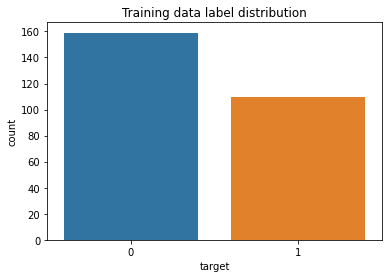

In [4]:
# Data exploration
print('Number of training slides:', len(df))

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Training data label distribution')
plt.show()

Slide name: tumor_094
Slide label: 1
Slide dimension: (118784, 100352)
Number of tiles: 7394
Tile size: 224
Tiling level: 16
Feature dimension: 2048


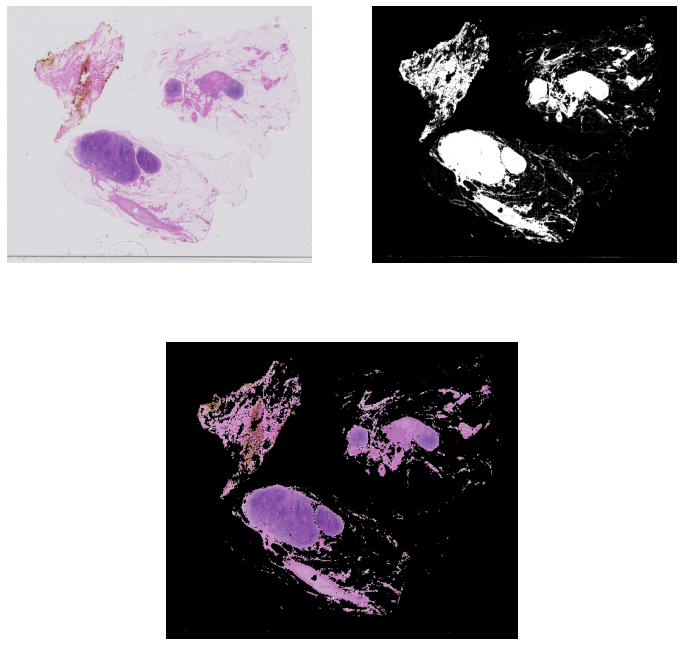

In [5]:
idx = np.random.randint(0, len(df), 1)[0]

row = df.iloc[idx]
slide_name, label = row.slide_name, row.target
slide = load_slide(slide_name)

mask = load_mask(slide_name, SAVE_PATH)
features = load_features(slide_name, SAVE_PATH)
metadata = load_metadata(slide_name, SAVE_PATH)

tile_size, level = metadata.tile_size, metadata.level

print('Slide name:', slide_name)
print('Slide label:', label)
print('Slide dimension:', slide.dimensions)
print('Number of tiles:', len(features))
print('Tile size:', tile_size)
print('Tiling level:', level)
print('Feature dimension:', features.shape[1]-3)

display_mask(slide, mask)

In [9]:
# Parameters
random_state = 42
device = 'cuda:1'

test_size = 0.40

bs_train = 4
bs_val = 8
bs_test = 8

model_name = 'MeanPool'
max_tiles = 100

num_epochs = 3
learning_rate = 1e-4

In [10]:
# Train/valid split
df_train, df_valid = train_test_split(df, test_size=test_size, random_state=random_state)

print('Train set:', len(df_train))
print('Valid set:', len(df_valid))
print('Test set:', len(df_test))

# Datasets
ds_train = CamelyonDataset(df_train, max_tiles=max_tiles)
ds_valid = CamelyonDataset(df_valid, max_tiles=max_tiles)
ds_test = CamelyonDataset(df_test, max_tiles=max_tiles)

# Dataloaders
dl_train = DataLoader(
    dataset=ds_train, 
    shuffle=True, 
    batch_size=bs_train,
    drop_last=True,
)
dl_valid = DataLoader(
    dataset=ds_valid, 
    shuffle=False, 
    batch_size=bs_train,
)
dl_test = DataLoader(
    dataset=ds_test, 
    shuffle=False, 
    batch_size=bs_train, 
)

Train set: 161
Valid set: 108
Test set: 130


In [11]:
# Define model, loss, optimizer
model = get_model(model_name).to(device)
criterion = BCEWithLogitsLoss().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

In [12]:
# Training
train_losses, valid_losses, train_metrics, valid_metrics = fit(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    train_dataloader=dl_train, 
    valid_dataloader=dl_valid, 
    num_epochs=num_epochs, 
    device=device,
)

100%|██████████| 27/27 [00:02<00:00, 10.77it/s]


Epoch: 1
Training loss: 0.7160984 ; Training metric: 0.3980179028132992
Validation loss: 0.6684837 ; Validation metric: 0.5266955266955267


100%|██████████| 27/27 [00:02<00:00, 11.06it/s]


Epoch: 2
Training loss: 0.6870847 ; Training metric: 0.45674851548708073
Validation loss: 0.66550726 ; Validation metric: 0.5595238095238095


100%|██████████| 27/27 [00:02<00:00, 11.15it/s]

Epoch: 3
Training loss: 0.6846279 ; Training metric: 0.48817135549872126
Validation loss: 0.66751695 ; Validation metric: 0.5768398268398268


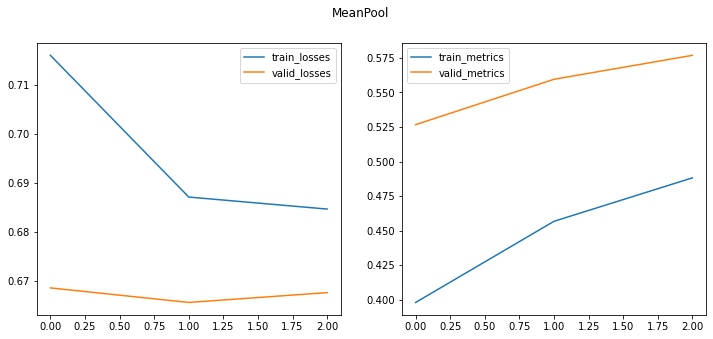

In [13]:
# Visualize loss and metric
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(train_losses, label='train_losses')
plt.plot(valid_losses, label='valid_losses')
plt.legend()

plt.subplot(122)
plt.plot(train_metrics, label='train_metrics')
plt.plot(valid_metrics, label='valid_metrics')
plt.legend()

plt.suptitle(model_name)
plt.show()

In [19]:
# Parameters
random_state = 42
device = 'cuda:1'

n_repeats, n_splits = 1, 5

bs_train = 4
bs_val = 8
bs_test = 8

model_name = 'MeanPool'
max_tiles = 100

num_epochs = 2
learning_rate = 1e-4

Train set: 80
Valid set: 20


100%|██████████| 5/5 [00:00<00:00,  8.30it/s]


Epoch: 1
Training loss: 0.6636733 ; Training metric: 0.4375
Validation loss: 0.65291893 ; Validation metric: 0.6043956043956044


100%|██████████| 5/5 [00:00<00:00,  8.32it/s]


Epoch: 2
Training loss: 0.62217677 ; Training metric: 0.4322916666666667
Validation loss: 0.6614224 ; Validation metric: 0.6043956043956044


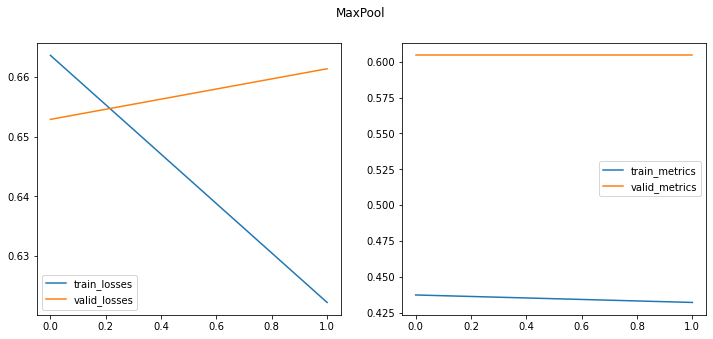

Train set: 80
Valid set: 20


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


Epoch: 1
Training loss: 0.75349164 ; Training metric: 0.42109090909090907
Validation loss: 0.6423837 ; Validation metric: 0.630952380952381


100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


Epoch: 2
Training loss: 0.63678634 ; Training metric: 0.5258181818181819
Validation loss: 0.60571665 ; Validation metric: 0.6190476190476191


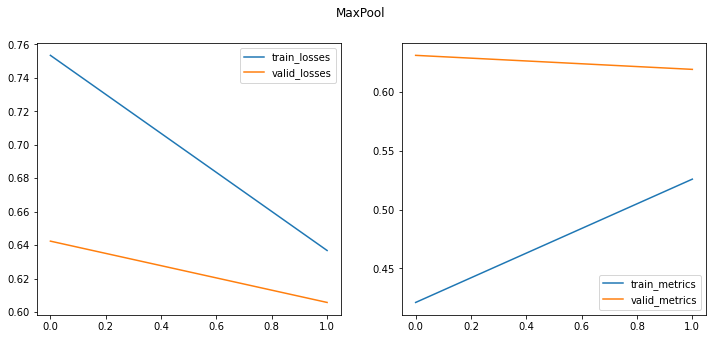

Train set: 80
Valid set: 20


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch: 1
Training loss: 0.64017713 ; Training metric: 0.4
Validation loss: 0.61998624 ; Validation metric: 0.5595238095238094


100%|██████████| 5/5 [00:00<00:00,  9.03it/s]


Epoch: 2
Training loss: 0.6277678 ; Training metric: 0.4276363636363637
Validation loss: 0.61985713 ; Validation metric: 0.5595238095238094


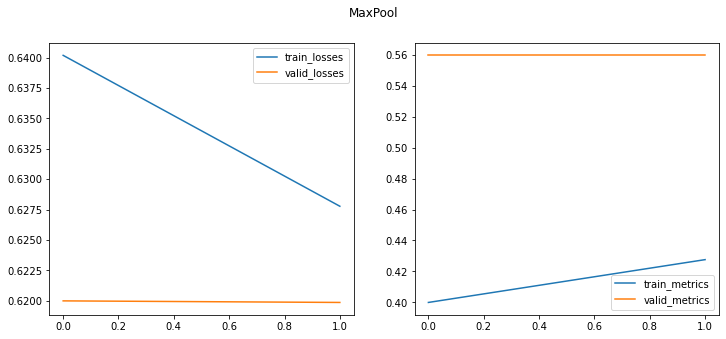

Train set: 80
Valid set: 20


100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch: 1
Training loss: 0.6170783 ; Training metric: 0.5534545454545455
Validation loss: 0.6283531 ; Validation metric: 0.38095238095238093


100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch: 2
Training loss: 0.6123761 ; Training metric: 0.5789090909090908
Validation loss: 0.6271795 ; Validation metric: 0.38095238095238093


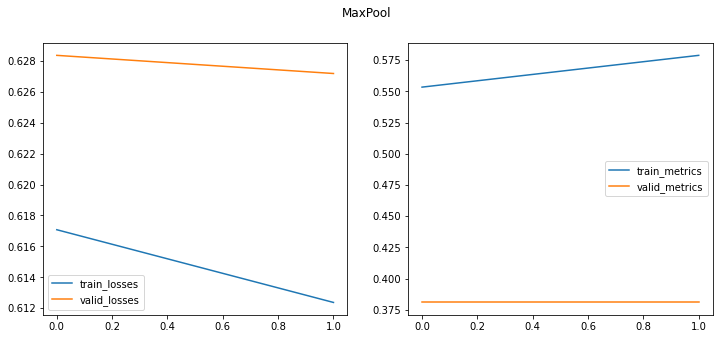

Train set: 80
Valid set: 20


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch: 1
Training loss: 0.7041351 ; Training metric: 0.47490909090909095
Validation loss: 0.62292176 ; Validation metric: 0.6666666666666666


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Epoch: 2
Training loss: 0.6289069 ; Training metric: 0.49090909090909096
Validation loss: 0.6010122 ; Validation metric: 0.6428571428571429


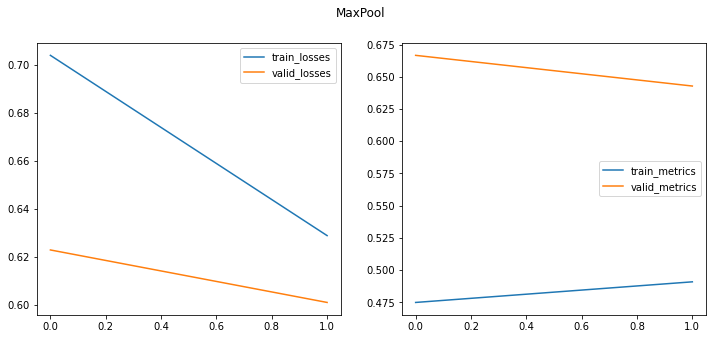

In [26]:
# Cross-validation
tmp = df.sample(n=100)

train_loss, train_metric, val_loss, val_metric = [], [], [], []
for _ in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits)
    for train_indices, valid_indices in skf.split(tmp, y=tmp.target):
        df_train, df_valid = tmp.iloc[train_indices], tmp.iloc[valid_indices]
        
        print('Train set:', len(df_train))
        print('Valid set:', len(df_valid))
        
        # Datasets
        ds_train = CamelyonDataset(df_train, max_tiles=max_tiles)
        ds_valid = CamelyonDataset(df_valid, max_tiles=max_tiles)

        # Dataloaders
        dl_train = DataLoader(
            dataset=ds_train, 
            shuffle=True, 
            batch_size=bs_train,
            drop_last=True,
        )
        dl_valid = DataLoader(
            dataset=ds_valid, 
            shuffle=False, 
            batch_size=bs_train,
        )

        # Define model, loss, optimizer
        model = get_model(model_name).to(device)
        criterion = BCEWithLogitsLoss().to(device)
        optimizer = Adam(model.parameters(), lr=learning_rate)
        
        # Training
        train_losses, valid_losses, train_metrics, valid_metrics = fit(
            model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=dl_train, 
            valid_dataloader=dl_valid, 
            num_epochs=num_epochs, 
            device=device,
        )
        
        # Visualize loss and metric
        plt.figure(figsize=(12, 5))

        plt.subplot(121)
        plt.plot(train_losses, label='train_losses')
        plt.plot(valid_losses, label='valid_losses')
        plt.legend()

        plt.subplot(122)
        plt.plot(train_metrics, label='train_metrics')
        plt.plot(valid_metrics, label='valid_metrics')
        plt.legend()

        plt.suptitle('MaxPool')
        plt.show()
        
        train_loss.append(train_losses[-1]); val_loss.append(valid_losses[-1])
        train_metric.append(train_metrics[-1]); val_metric.append(valid_metrics[-1])

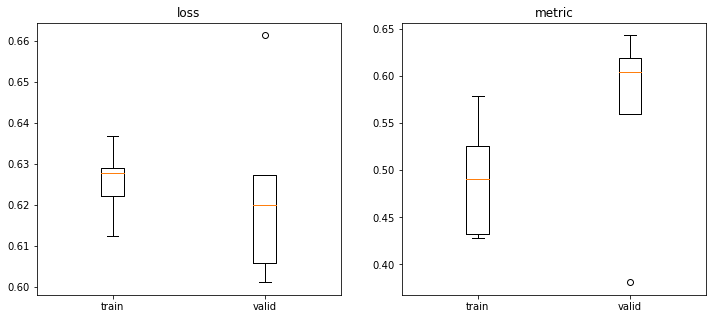

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(121); plt.boxplot([train_loss, val_loss])
plt.xticks([1, 2], ['train', 'valid']); plt.title('loss')

plt.subplot(122); plt.boxplot([train_metric, val_metric])
plt.xticks([1, 2], ['train', 'valid']); plt.title('metric')

plt.show()